

# Hypothesis Testing, and P-Values

First, to motivate these topics, lets get some data. Today, we will use a popular toy dataset called mtcars. **mtcars** is a dataset of 32 cars (and their attributes) from a 1974 Motor Trend Magazine. Lets go through some basic setup first and look of the data. 


In [3]:
#import necessary packages and modules
from IPython.display import display
import numpy as np
import pandas as pd
from ggplot import mtcars
import matplotlib
import matplotlib.pyplot as plt
import scipy.stats as stats
import best
import best.plot
from pymc import MCMC as pm
import seaborn as sns
%matplotlib inline 
matplotlib.style.use('ggplot')

In [2]:
df=pd.DataFrame(mtcars)
display(df.shape) #there are 32 rows and 12 columns
display(df.head(5)) #shows first 5 rows of dataset. 

(32, 12)

,name,mpg,cyl,disp,hp,drat,wt,qsec,vs,am,gear,carb
0,Mazda RX4,21.0,6,160.0,110,3.90,2.620,16.46,0,1,4,4
1,Mazda RX4 Wag,21.0,6,160.0,110,3.90,2.875,17.02,0,1,4,4
2,Datsun 710,22.8,4,108.0,93,3.85,2.320,18.61,1,1,4,1
3,Hornet 4 Drive,21.4,6,258.0,110,3.08,3.215,19.44,1,0,3,1
4,Hornet Sportabout,18.7,8,360.0,175,3.15,3.440,17.02,0,0,3,2


As we can see from the first *df.shape* command above, this dataset contains 32 rows (cars) and 12 columns (car attributes).

There are many questions one may have when looking at these data. One such question may be **do heavier cars have a lower average Miles Per Gallon(MPG) than lighter cars?** There are many ways that we could address this question. First we must decide how we should define what is a **Heavy** car and what is a **Light** car. To keeps things simple, lets define heavy cars to be cars in our dataset which have weights above the median (roughly 3,325 Lbs in our dataset) and light cars to be cars in our dataset which are less than or equal to the median. 

To add this column to the dataset we can run the following code below.

In [4]:
#Create new binary variable for whether the car is heavy or light.
#Cutoff for heavy will be if the car is above the median wt for 
#all the cars in the dataset. Wt in this dataset is in 1,000's of Lbs.
display(np.median(df['wt']))
df['wtCat']=np.where(df['wt']>np.median(df['wt']), "Heavy", 'Light')
display(df.shape)
df.head(5) #display first 5 rows of the dataset.

3.3250000000000002

(32, 13)

,name,mpg,cyl,disp,hp,drat,wt,qsec,vs,am,gear,carb,wtCat
0,Mazda RX4,21.0,6,160.0,110,3.90,2.620,16.46,0,1,4,4,Light
1,Mazda RX4 Wag,21.0,6,160.0,110,3.90,2.875,17.02,0,1,4,4,Light
2,Datsun 710,22.8,4,108.0,93,3.85,2.320,18.61,1,1,4,1,Light
3,Hornet 4 Drive,21.4,6,258.0,110,3.08,3.215,19.44,1,0,3,1,Light
4,Hornet Sportabout,18.7,8,360.0,175,3.15,3.440,17.02,0,0,3,2,Heavy


## Hypothesis Testing
One way to answer our question, **do heavier cars have a lower average MPG than lighter cars**, is to do conduct a statistical hypothesis test. Traditional statistical hypothesis testing (HT) approaches this subject by first designating a *Null* and *Alternative* hypothesis. More plainly said, the *Null* hypothesis is a statement about your question(or hypothesis) which indicates no (*Null*) effect. In our example the *Null* hypothesis would be: **heavier cars have the same average MPG as lighter cars**. The *Alternative Hypothesis* is the complement of the *Null* hypothesis. In our example the *Alternative* hypothesis is: **heavier cars do not have the same average MPG as lighter cars**. More formally, statisticians typically denote the *Null* and *Alternative* hypothesis in the following way: 

$
\begin{eqnarray*}
H_{0} & : & \mu_{Heavy}=\mu_{Light}\\
H_{A} & : & \mu_{Heavy}\ne\mu_{Light}
\end{eqnarray*}
$

Here the $\mu_{Heavy}$ represents the **true** mean MPG for heavy($wt>3,325lbs$) cars while $\mu_{Light}$ represents the **true** mean MPG for the light($wt\le3,325lbs$) cars. With our (assumed) randomly collected dataset, we hope to estimate these population *parameters* and come to a conclusion about our *Null* hypothesis. 

To estimate these parameters ($\mu_{Heavy}$, and $\mu_{Light}$), we can use the arithmetic mean (average) from the dataset. This is calculated in the traditional sense $\bar{x} = \frac{1}{n}\left (\sum_{i=1}^n{x_i}\right ) = \frac{x_1+x_2+\cdots +x_n}{n}$ (sum of the values and divide by the number) .

In python we calculate the two means $\bar{MPG}_{Heavy}$, and $\bar{MPG}_{Light}$ in the following way:

In [5]:
print("Average MPG_Heavy:",np.mean(df[df['wtCat']=="Heavy"]["mpg"]))
print("Average MPG_Light:",np.mean(df[df['wtCat']=="Light"]["mpg"]))
print("Sample Size MPG_Heavy:",np.count_nonzero(df[df['wtCat']=="Heavy"]["mpg"]))
print("Sample Size MPG_Light:",np.count_nonzero(df[df['wtCat']=="Light"]["mpg"]))

Average MPG_Heavy: 15.66875
Average MPG_Light: 24.5125
Sample Size MPG_Heavy: 16
Sample Size MPG_Light: 16


As we can see, from our dataset, the average MPG for Heavy Cars is less then the average MPG for Lighter Cars. While this is evidence for the alternative hypothesis, statisticians would argue that this result could have been due to chance and is not statistically rigorous enough. To determine if this difference is large enough to say that we have *statistical evidence to support the alternative hypothesis* we compute the following $t$ statistic: $t = \dfrac{\bar{MPG}_{Heavy} - \bar{MPG}_{Light}}{s_p \sqrt\frac{2}{n}}$, here $s_{p}=\sqrt{\dfrac{s_{MPG_{Heavy}}^{2}+s_{MPG_{Light}}^{2}}{2}}$. If this $t$ statistic is large enough then we *reject the Null hypothesis* and conclude that we have sufficient evidence for the alternative. How large, is large enough? The answer comes back to whether this result could be due to chance.

## P-Values

To argue the point of chance, imagine that we were to collect a new set of 32 cars and calculate their MPG. These cars MPG will differ from our original 32. This variability is called **sampling variability**. If the sampling variability is estimated to be small and the difference in the two groups are large , then statistical theory tells us that the result would unlikely be due to chance. This trade off is reflected in the magnitude of the $t$ statistic. The **sampling distribution** is the theoretical distribution of the statistic from many collections of data (same sample size) from the population of interest. 

Statisticians have determined the **sampling distribution** for the $t$ statistic under the *null* hypothesis. This $t$ statistic, under the *null*, will follow a t distribution with $2n-2$ degrees of freedom. 

The $t$ distribution is similar to the *normal distribution*. If you compute the area under either curves, you will always get 1. The difference the two distributions is the degrees of freedom on the $t$ determines how wide the tail of the distribution is. The smaller degrees of freedom, the wider the tails. As the degrees of freedom become very large, the t-distribution will closely approximate a normal distribution. 

To illustrate this, see the following graph:

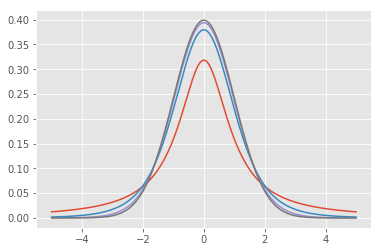

In [6]:
rv1 = stats.t(df=1, loc=0, scale=1) # t distribution with 1 degrees of freedom #blue
rv5 = stats.t(df=5, loc=0, scale=1) # t distribution with 5 degrees of freedom #green
rv20 = stats.t(df=20, loc=0, scale=1) # t distribution with 20 degrees of freedom #red
rvN = stats.norm() #normal distribution mean 0 sd 1. #black
x = np.linspace(-5, 5, 1000)
plt.plot(x,rv1.pdf(x),x,rv5.pdf(x),x,rv20.pdf(x),x,rvN.pdf(x))


As we can see, the $t$-distribution with smaller degrees of freedom has wider tails. As the degrees of freedom gets larger, the distribution more closely resembles a normal distribution (black). 

Here is the theoretical sampling distribution for our t-statistic on $30$ ($2\times16-2$) degrees of freedom. 

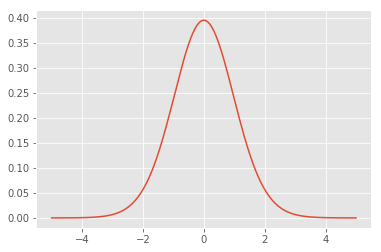

In [7]:
rv30 = stats.t(df=30, loc=0, scale=1) # t distribution with 30 degrees of freedom #red
x = np.linspace(-5, 5, 1000)
plt.plot(x,rv30.pdf(x))

This distribution reflects the $t$ statistics that we would likely see if the null hypothesis is true. As we can see, it is likely to see $t$ statistics around 0, and unlikely around 5 or -7.5. 

To calculate the $t$ statistic (for equal variances) for our data in python we can do:

In [8]:
stats.ttest_ind(
    df[df['wtCat']=="Heavy"]["mpg"],
    df[df['wtCat']=="Light"]["mpg"],
    equal_var=True
)

Ttest_indResult(statistic=-6.1249748852887702, pvalue=9.8369312250035616e-07)

As we can see, the $t$ statistic is calculated to be $-6.125$. By looking at our graph above, we can see that these values are uncommon under the null hypothesis. To calculate the probability, under the null hypothesis, that we would see a value as extreme as $-6.125$ or smaller we can determine the area under the t-distribution (integration) from $-\infty$ to $-6.1249748852887702$. In python this probability can be numerically approximated in the following way:

In [9]:
stats.t(df=30).cdf(-6.1249748852887702)

4.9184656125017808e-07

Note, that this probability refers to $P(T<-6.125)$, whereas our alternative hypothesis was a statement of $\ne$, so we are also interested in the $P(T>6.125)$ as well. Because the t-distribution is symmetrical we can just compute $2\times P(T<-6.125)$ which is:

In [10]:
stats.t(df=30).cdf(-6.1249748852887702)*2

9.8369312250035616e-07

Note that this probability is the same that was reported from the *stats.ttest_ind* function above.

This probability of $9.837\times 10^{-7}$ is what statisticians refer to as the p-value. We interpret the $t$ statistic and p-value in the following way: Under the assumption that the average MPG of heavy and light cars are no different, in repeated sampling, we would expect to see a difference as or more extreme then the one we saw with probability $9.8\times 10^{-7}$. Therefore, we reject the *Null* hypothesis and conclude that there is statistical evidence in favor of the alternative hypothesis.

### Other notes and details

#### Assumptions
1. Independent Observations
2. Equal Variance Across Groups in Population
3. Dependent Variable is Normally Distributed in Population

#### Precision and Recall

Type 1 Error: Incorrect rejection of a True null hypothesis >> False Positives

Type 2 Error: Incorrect retention of a false null hypothesis >> False Negatives

Precision/Sensitivity: How well do we reject false null hypothesis >>Less False Positives

Recall: How well do we retain true null hypothesis>> Less False Negatives


### Conclusion

Hypothesis testing is a formal way of testing a statement about a parameter(s) of interest. P-Values are the mechanism from which we are able to drive our conclusion.


# Bayes Rule

Bayes rule says for events $A$ and $B$ that the conditional probability of $A$ given $B$ is equal to the product of the conditional probability of $B$ given $A$ times the probability of $A$ divided by the probability of $B$. Or in mathematical notation: $P(A\mid B) = \frac{P(B \mid A) \, P(A)}{P(B)}$. This is to say, the probability of event $A$ happening given that B already happened is a function of the prior probability of $A$ ($P(A)$), and the support $B$ provides for $A$ ($\frac{P(B \mid A)}{P(B)}$).


# Bayesian Posterior Inference

To motivate Bayesian Posterior Inference, lets take a look at our previous example, and dataset **mtcars**. 

First, we plot histograms of the MPG for "Heavy" and "Light" cars:

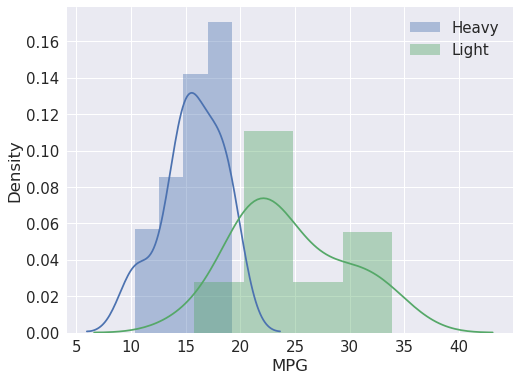

In [11]:
Heavy= df[df['wtCat']=="Heavy"]["mpg"]
Light= df[df['wtCat']=="Light"]["mpg"]

%matplotlib inline

sns.set(font_scale=1.5)
plt.figure(figsize=(8,6))

sns.distplot(Heavy)
sns.distplot(Light)

plt.xlabel('MPG')
plt.ylabel('Density')
plt.legend(['Heavy', 'Light'])

plt.show()

As we can see, the two distributions for Heavy and Light are quite different. It seems unlikely that the underlying population distributions have the same variance and they are possibly not normally distributed. Knowing that these are potentially untrue, we should question our original $t$ test, because two of our assumptions were normality and equal variances. 

As an alternative, a Bayesian framework for statistical inference can be used. Here, I will introduce this framework. As we will see, the Bayesian framework can be adapted to many types of data with varying levels of assumptions about its underlying distribution. 

In a Bayesian framework we are interested obtaining the posterior density of some parameter $\mu$ given the data that we have seen, $p(\mu \mid x)$. Bayes rule says that we can write this as:

$p(\mu \mid x) = \frac{p(x \mid \mu) p(\mu)}{p(x)}$, where $p(x)=\sum_\mu p(\mu)p(x|\mu)$, or $p(x)=\int p(\mu)p(x|\mu)d\mu$ if $\mu$ is continuous. Here, because $p(x)$ does not depend on $\mu$ and $x$ is fixed it can be considered a constant. So the *unnormalized posterior density* can be written as: $p(\mu \mid x) \propto p(x \mid \mu) p(\mu)$. Which it can be said that the posterior distribution is proportional to the prior distribution times the likelihood function of the data (x) given $\mu$.

In practice, we can use this proportionality to determine the distributional form and then work our way backwards to determine the appropriate constant that should go along with it. It is often up to the statistician to choose a distribution which the data follow (likelihood) as well as a choice for the distribution of the prior belief for the parameter ($\mu$). 

It is not guaranteed that the statisticians choice of a likelihood and prior will yield a closed form solution for the posterior distribution. In this case, numerical techniques such as monte carlo markov chains (gibbs sampling) can be used to numerically approximate the posterior distribution. If the statistician chooses $p(x|\mu)$ and $p(\mu)$ such that their product results in a function of the same form as $p(\mu)$, it is said that the prior and posterior are conjugate distributions. When conjugate priors are chosen, a closed form (formally written) posterior is obtainable. This allows for easier posterior inference on parameters of interest. 

## Conjugate Prior Example (Normal-Normal with known Variance)

Let $x \mid \mu \sim N(\mu,\sigma^2)$ with $\sigma^2$ known, and let $\mu \sim N(\mu_0,\sigma_0^2$). Then by bayes rule we know the *unnormalized posterior density* is:

$p(\mu \mid x) \propto p(x\mid\mu,\sigma)p(\mu\mid\mu_0,\sigma_0^2)$

$p(\mu \mid x) \propto \prod_{i=1}^n \sqrt{\frac{1}{2\pi\sigma^2}} \exp\left(-\frac{1}{2\sigma^2}(x_i-\mu)^2\right) \cdot \sqrt{\frac{1}{2\pi\sigma_0^2}} \exp\left(-\frac{1}{2\sigma_0^2}(\mu-\mu_0)^2\right)$

$\dots$

$p(\mu \mid x) \propto \exp\left(-\frac{n}{2\sigma^2}(\bar{x}-\mu)^2\right) \cdot \exp\left(-\frac{1}{2\sigma_0^2}(\mu-\mu_0)^2\right)$ As we can see, this is the product of two unnormalized normal distributions, which will be normal. 

$\dots$

more $\dots$ complete the square and $\dots$

$p(\mu \mid x) \propto \exp\left(-\frac{1}{2\sigma_n^2}(\mu-\mu_n)^2\right)$ where $\mu_n=\sigma_n^2(\frac{\mu_0}{\sigma_0^2}+\frac{n\bar{x}}{\sigma^2})$, and $\sigma^2_n=\frac{1}{\frac{n}{\sigma^2}+\frac{1}{\sigma_0^2}}$

In this form we recognize this as a *unnormalized* normal distribution with mean $\mu_n$ and variance $\sigma_n^2$.


Because the posterior distribution ($p(\mu \mid x)$) is the same form as the Normal prior (with known variance) is called a **conjugate prior** for the normal likelihood.

## Example: Posterior Inference with mtcars

Now that we have derived the posterior distribution for a normal prior and normal likelihood with known variance, lets put it to use. 

Lets say we heard from a friend that Light cars average less than 20 MPG. We can use the **mtcars** dataset to test if $\mu{Light}<20$. Let us assume that the variance of our $\mu_{Light}$ is $6^2$. Prior to observing our data, lets assume that we believed our friend ($\mu_{Light}=20$), and assigned a variance of their estimate equal to $10^2$. So we have


$x \mid \mu_{Light} \sim N(\mu,6^2) $

$\mu_{Light} \sim N(\mu_0=20,\sigma_0=10^2)$

From our previous result we know:

$p(\mu_{Light} \mid x)=N(\mu_n,\sigma_n^2)$, where $\sigma_n^2=\frac{1}{\frac{16}{6^2}+\frac{1}{10^2}}\approx2.2$ and $\mu_n=2.2(\frac{20}{10^2}+\frac{n\bar{x}}{6^2})$

Now to compute the mean of the light cars and we will have the normal distribution:


In [22]:
np.mean(df[df['wtCat']=="Light"]["mpg"])

24.5125

So we have $\mu_{Light} \mid x \sim N(24.41,2.2)$. From this posterior distribution we can calculate $P(\mu<20)$. To show the posterior distribution in python and calculate this probability and an 95% *credible* interval. 

Bayesian P-value (the probability, given the data, that a future mean is more extreme than 20): 0.0011807694846
95% Bayesian Credible Interval (range of values within which an \mu_Light value falls with a 95% probability): ( 21.5992 , 27.4008 )


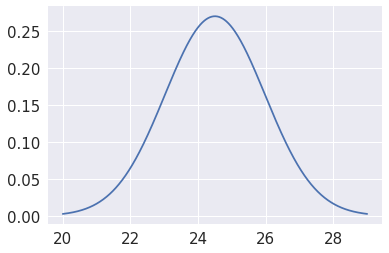

In [23]:
nm = stats.norm(loc=24.5,scale=1.48) 
x = np.linspace(20, 29, 1000)
plt.plot(x,nm.pdf(x))
print("Bayesian P-value (the probability, given the data, that a future mean is more extreme than 20):", nm.cdf(20))
print("95% Bayesian Credible Interval (range of values within which an \mu_Light value falls with a 95% probability): (",24.5-1.96*1.48,",",24.5+1.96*1.48,")")

This past example was meant to show how the Bayesian framework can be used when we have conjugate priors for our likelihood functions. As you saw, there were still many assumptions about the data and the parameter of interest that we needed to make. 

In practice however, we are able to work in a framework which doesn't make as many strong assumptions. A paper titled "Bayesian estimation supersedes the t test" [Bayesian estimation supersedes the t test](http://www.indiana.edu/~kruschke/BEST/BEST.pdf) describes this framework and has written R and python packages to perform inference. The code to conduct our original *mtcars* $t$ test in a Bayesian framework is below. 

In [24]:
import pymc as pm
import numpy as np
import seaborn as sns

def setup_priors(data):
    ''' setup priors. takes in combined populations as input'''
    priors = dict()

    # Setup our priors
    lower = np.var(data)/1000.0
    upper = np.var(data)*1000

    v = pm.Exponential("nu", beta=1.0/29) + 1
    tau = 1.0/np.var(data)/1000.0
    mu1 = pm.Normal('mu1', mu=np.mean(data), tau=tau)
    var1 = pm.Uniform('var1', lower=lower, upper=upper)

    mu2 = pm.Normal('mu2', mu=np.mean(data), tau=tau)
    var2 = pm.Uniform('var2', lower=lower, upper=upper)

    priors['mu1'] = mu1
    priors['var1'] = var1
    priors['mu2'] = mu2
    priors['var2'] = var2
    priors['v'] = v
    
    return priors

def generate_models(values, values2, priors):
    '''generate models based on priors and given samples'''
    v = priors['v']
    mu1 = priors['mu1']
    var1 = priors['var1']
    lam1 = 1.0/var1

    mu2 = priors['mu2']
    var2 = priors['var2']
    lam2 = 1.0/var2

    # Include our observed data into the model
    t1 = pm.NoncentralT("t1", mu=mu1, lam=lam1, nu=v, value=values, observed=True)
    t2 = pm.NoncentralT("t2", mu=mu2, lam=lam2, nu=v, value=values2, observed=True)
    # Push our priors into a model
    model = pm.Model([t1, mu1, var1, t2, mu2, var2, v])
    
    return model

In [17]:
priors = setup_priors(np.concatenate((Heavy, Light), axis=0))
model = generate_models(Heavy, Light, priors)
mcmc = pm.MCMC(model)  # Generate our MCMC object
mcmc.sample(40000, 10000, 2)  # Run MCMC sampler

 [-----------------100%-----------------] 40000 of 40000 complete in 8.3 sec

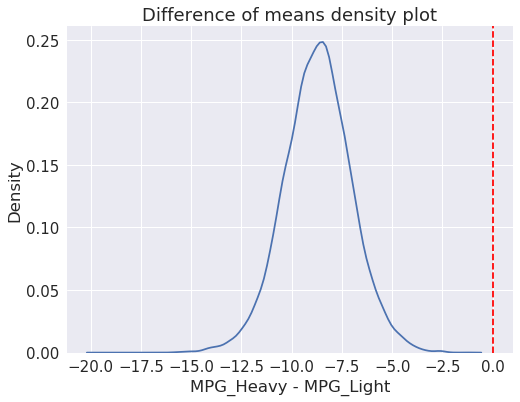

In [20]:
mu1 = mcmc.trace('mu1')[:] #get posterior means
mu2 = mcmc.trace('mu2')[:]
diff_mus = mu1-mu2 #calculate the difference of the means

sns.set(font_scale=1.5)
plt.figure(figsize=(8,6))

sns.kdeplot(diff_mus)
plt.title('Difference of means density plot')
plt.vlines(0,0,0.45, linestyles='--', color='r')
plt.ylabel('Density')
plt.xlabel('MPG_Heavy - MPG_Light')
plt.show()

In [21]:
sum(diff_mus>0)/40000

0.0